In [2]:
"""
    The program is the solution I have developed for assignment 1 in DD2424, Deep Learning in Data Science at KTH. 
    @Author: Isak Gamnes Sneltvedt
    @Date (last modified): 19.05.2022
"""

'\n    The program is the solution I have developed for assignment 1 in DD2424, Deep Learning in Data Science at KTH. \n    @Author: Isak Gamnes Sneltvedt\n    @Date (last modified): 19.05.2022\n'

In [92]:
import numpy as np
from sklearn.metrics import precision_score, accuracy_score
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import math
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
from numpy import random
import pandas as pd

In [4]:
def load_batch(file):
    """ Copied from: https://www.cs.toronto.edu/~kriz/cifar.html """
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        X = dict[b'data']    # Data (3072x10000)
        Y = np.array(dict[b'labels']) # Labels as numbers
        encoded_Y = np.zeros((len(Y), np.max(Y)+1), dtype=int) 
        encoded_Y[np.arange(len(Y)), Y] = 1 # This gives each row 0 for all elements execpt for the number in each row in Y. Ex. Y = 3, encoded_Y = [0,0,0,1,0,0,0,0,0,0]
    return np.transpose(X), np.transpose(Y), np.transpose(encoded_Y) 

In [5]:
def montage(images, rows=2, cols=5):
	""" Display the image for each label in W """
	import matplotlib.pyplot as plt
	fig, ax = plt.subplots(rows,cols)
	for i in range(rows):
		for j in range(cols):
			im  = images[i*cols+j,:].reshape(32,32,3, order='F')
			sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))
			sim = sim.transpose(1,0,2)
			ax[i][j].imshow(sim, interpolation='nearest')
			ax[i][j].set_title("y="+str(cols*i+j))
			ax[i][j].axis('off')
	plt.show()

def normalize_data(data):
    std_data = np.std(data, axis=0)
    data = data - np.mean(data, axis=0)
    data = data / std_data
    return data

In [138]:
def init_params(layer_sizes, He=True, BN=True, mean=0, std_dev=0.01):
    n_layers = len(layer_sizes)
    W = []
    b = []
    betas = []
    gammas = []
    include_gamma_beta = False
    
    for layer in range(n_layers-1):
        # Use careful initialization
        if He:
            # He definition:
            # https://machinelearning.wtf/terms/he-initialization/#:~:text=He%20initialization%20initializes%20the%20bias%20vectors%20of%20a,l%20is%20the%20dimension%20of%20the%20previous%20layer.

            # Create random gaussian distribution with 0 mean and 1 variance
            layer_W = np.random.randn(layer_sizes[layer+1], layer_sizes[layer])
            # Mulitply by sqrt(2/nl) where nl is the size of a previous layer to get He init
            layer_W *= np.sqrt(2/layer_sizes[layer])

            # If batch norm, init b as zeros, else use He
            if BN:
                layer_b = np.zeros((layer_sizes[layer+1], 1))
            else:
                layer_b = np.random.randn(layer_sizes[layer+1], 1)
                layer_b *= np.sqrt(2/layer_sizes[layer])

        # Else, use old init
        else:
            layer_W = np.random.normal(mean, std_dev, (layer_sizes[layer+1], layer_sizes[layer]))
            layer_b = np.random.normal(mean, std_dev, (layer_sizes[layer+1],1))



        W.append(layer_W)
        b.append(layer_b)
        if include_gamma_beta:
            if BN:
                gammas.append(np.ones((layer_sizes[layer],1)))
                betas.append(np.zeros((layer_sizes[layer],1)))
            else:
                gammas.append(np.random.normal(mean, std_dev, (layer_sizes[layer],1)))
                betas.append(np.random.normal(mean, std_dev, (layer_sizes[layer],1)))
        else:
            include_gamma_beta = True
    return W, b, gammas, betas

def evaluate_classifier(X, W, b, gamma, beta, BN):
    num_layers = len(W)
    # Initialize variables and allocate memory
    layer_X = [X.copy()] + [None]*(num_layers-1)
    S = [None]*(num_layers-1)
    S_hat = [None]*(num_layers-1)
    layer_means = [None]*(num_layers-1)
    layer_vars = [None]*(num_layers-1)

    for layer in range(num_layers-1):
        S[layer] = np.matmul(W[layer],layer_X[layer]) + b[layer]

        if BN:
            layer_means[layer] = S[layer].mean(axis=1).reshape(-1,1)
            layer_vars[layer] = S[layer].var(axis=1).reshape(-1,1)
            
            S_hat[layer] = (S[layer]-layer_means[layer])/(np.sqrt(layer_vars[layer]+1e-10))
            S_tilde = np.multiply(S_hat[layer], gamma[layer]) + beta[layer]
            S_tilde[S_tilde<0] = 0
            layer_X[layer+1] = S_tilde

        else:
            S_temp = S[layer]
            S_temp[S_temp<0] = 0
            layer_X[layer+1] = S_temp
    S_out = np.matmul(W[num_layers-1], layer_X[num_layers-1]) + b[num_layers-1]
    P = np.exp(S_out)/np.sum(np.exp(S_out), axis=0)
    return P, S, S_hat, layer_X[1:], layer_means, layer_vars

def compute_cost(X, Y, W, b, gamma, beta, lambda_val, BN):
    P = evaluate_classifier(X, W, b, gamma, beta, BN)[0]
    square_sum = [np.sum(np.square(w)) for w in W]
    regularization_term = lambda_val*np.sum(square_sum)
    D = X.shape[1]
    cross_loss = -np.sum(np.multiply(Y, np.log(P)))
    return (cross_loss/D) + regularization_term

def compute_accuracy(X, y, W, b, gamma, beta, BN):
    P = evaluate_classifier(X, W, b, gamma, beta, BN)[0]
    y_pred = np.argmax(P, axis=0)
    return accuracy_score(y, y_pred)

def compute_gradients(X, Y, W, b, gamma, beta, lambda_val, BN=True):
    P, S, S_hat, layer_X, layer_means, layer_vars = evaluate_classifier(X, W, b, gamma, beta, BN)
    k = len(W)
    N = X.shape[1]
    dJdW = [None]*k
    dJdB = [None]*k

    if BN:
        layer_X = [X.copy()] + layer_X
    else:
        layer_X = [X.copy()] + S

    # Propagate the gradient through the loss and softmax operations
    G_batch = -(Y - P)

    # The gradients of J w.r.t. bias vector bk and weight matrix Wk
    dJdW[k-1] = np.matmul(G_batch, np.transpose(layer_X[k-1]))/N + 2*lambda_val*W[k-1]
    dJdB[k-1] = np.matmul(G_batch, np.ones((N,1)))/N
    
    # Propagate G_batch to the previous layer
    G_batch = np.matmul(np.transpose(W[k-1]), G_batch)
    G_batch = np.multiply(G_batch, (layer_X[k-1] > 0))

    # Allocate memory for gamma and beta gradients
    dJdGamma = [None]*(k-1)
    dJdBeta = [None]*(k-1)

    # For layer = k − 2, k − 3, . . . , 0
    for layer in range(k-2, -1, -1):
        if BN:
            dJdGamma[layer] = np.matmul(np.multiply(G_batch, S_hat[layer]), np.ones((N,1)))/N
            dJdBeta[layer] = np.matmul(G_batch, np.ones((N,1)))/N
            G_batch_BN = np.multiply(G_batch, np.matmul(gamma[layer], np.ones((1,N))))
            G_batch = batch_norm_back_pass(G_batch_BN, S[layer], layer_means[layer], layer_vars[layer])
        
        dJdW[layer] = np.matmul(G_batch, np.transpose(layer_X[layer]))/N + 2*lambda_val*W[layer]
        dJdB[layer] = np.matmul(G_batch, np.ones((N,1)))/N

        if layer > 0:
            G_batch = np.matmul(np.transpose(W[layer]), G_batch)
            G_batch = np.multiply(G_batch, layer_X[layer] > 0)
    return dJdW, dJdB, dJdGamma, dJdBeta, layer_means, layer_vars

def compute_grads_num(X, Y, W, b, gamma, beta, lambda_val, BN=True, h=1e-5):
    k = len(W)

    dJdW = [None]*k
    dJdB = [None]*k
    dJdGamma = [None]*(k-1)
    dJdBeta = [None]*(k-1)
    
    for layer in range(len(W)):

        grad_b = np.zeros(b[layer].shape)
        
        for i in range(grad_b.shape[0]):
            b_temp = b.copy()
            b_try = b_temp[layer]
            b_try[i] += h
            b_temp[layer] = b_try
            c1 = compute_cost(X, Y, W, b_temp, gamma, beta, lambda_val, BN)
            
            b_temp = b.copy()
            b_try = b_temp[layer]
            b_try[i] -= h
            b_temp[layer] = b_try
            c2 = compute_cost(X, Y, W, b_temp, gamma, beta, lambda_val, BN)
            grad_b[i] = (c2-c1) / h
        dJdB[layer] = grad_b

        grad_W = np.zeros(W[layer].shape)
        for i in range(grad_W.shape[0]):
            for j in range(grad_W.shape[1]):
                W_temp = W.copy()
                W_try = W_temp[layer]
                W_try[i,j] += h
                W_temp[layer] = W_try
                c1 = compute_cost(X, Y, W_temp, b, gamma, beta, lambda_val, BN)
                
                W_temp = W.copy()
                W_try = W_temp[layer]
                W_try[i,j] -= h
                W_temp[layer] = W_try
                c2 = compute_cost(X, Y, W_temp, b, gamma, beta, lambda_val, BN)
                grad_W[i,j] = (c2-c1) / h
        dJdW[layer] = grad_W

    for layer in range(len(W)-1):
        grad_beta = np.zeros(beta[layer].shape)
        for i in range(grad_beta.shape[0]):
            beta_temp = beta.copy()
            beta_try = beta_temp[layer]
            beta_try[i] += h
            beta_temp[layer] = beta_try
            c1 = compute_cost(X, Y, W, b, gamma, beta_temp, lambda_val, BN)
            
            beta_temp = beta.copy()
            beta_try = beta_temp[layer]
            beta_try[i] -= h
            beta_temp[layer] = beta_try
            c2 = compute_cost(X, Y, W, b, gamma, beta_temp, lambda_val, BN)

            grad_beta[i] = (c2-c1) / h
        dJdBeta[layer] = grad_beta

        grad_gamma = np.zeros(gamma[layer].shape)
        for i in range(grad_gamma.shape[0]):
            gamma_temp = gamma.copy()
            gamma_try = gamma_temp[layer]
            gamma_try[i] += h
            gamma_temp[layer] = gamma_try
            c1 = compute_cost(X, Y, W, b, gamma_temp, beta, lambda_val, BN)
            
            gamma_temp = gamma.copy()
            gamma_try = gamma_temp[layer]
            gamma_try[i] -= h
            gamma_temp[layer] = gamma_try
            c2 = compute_cost(X, Y, W, b, gamma_temp, beta, lambda_val, BN)
            
            grad_gamma[i] = (c2-c1)/h
        dJdGamma[layer] = grad_gamma

    return dJdW, dJdB, dJdGamma, dJdBeta

def compare_computed_gradients(ga, gn, eps=1**(-7)):
    # Default eps value comes from the Standford’s course Convolutional Neural Networks for Visual Recognition recommendation 
    # https://cs231n.github.io/neural-networks-3/#gradcheck
    relative_error = [np.abs(ga_i - gn_i).sum() for ga_i, gn_i in zip(ga, gn)]
    denom = [max(eps, np.abs(ga_i + gn_i).sum()) for ga_i, gn_i in zip(ga, gn)]
    test = [relative_error_i/denom_i < eps for relative_error_i, denom_i in zip(relative_error, denom)]
    return test

def batch_norm_back_pass(G_batch, S_batch, mean, var):
    n = S_batch.shape[1]
    sigma_1 = (var+1e-10)**(-0.5)
    sigma_2 = (var+1e-10)**(-1.5)
    G1 = np.multiply(G_batch,np.matmul((sigma_1),np.ones((1,n))))
    G2 = np.multiply(G_batch,np.matmul((sigma_2),np.ones((1,n))))
    D = S_batch-np.matmul(mean,np.ones((1,n)))
    c = np.matmul(np.multiply(G2,D),np.ones((n,1)))
    
    return G1 - (np.matmul(G1, np.ones((n,1)))) / n - np.multiply(D, np.matmul(c, np.ones((1,n)))) / n

def gradient_descent(X, Y, y, X_val, Y_val, y_val, n_batch, eta, n_epochs, W, b, gamma, beta, lambda_val, alpha, eta_min=1e-5, eta_max=1e-1, n_s=500, step_decay=False, use_CLR=False, BN=True):
    total_length = X.shape[1]
    training_accuracy = []
    training_loss = []
    validation_accuracy = []
    validation_loss = []
    eta_evolution = []
    k_list1 = list(range(0, n_s, 1))
    k_list2 = list(range(n_s, 0, -1))
    k_list = np.concatenate([k_list1, k_list2], axis=0)
    cycle_idx = 0

    for epoch in tqdm(range(n_epochs)):
        # From 0 to the total length of the data set. n_batch makes "batch" increase by n_batch (batch size) for each iteration.
        for batch in range(0, total_length, n_batch):
            max_batch_idx = batch+n_batch
            Y_batch = Y[:,batch:max_batch_idx]
            X_batch = X[:,batch:max_batch_idx]
            
            grad_W, grad_b, grad_gamma, grad_beta, layer_means, layer_vars = compute_gradients(X_batch, Y_batch, W, b, gamma, beta, lambda_val, BN)
            

            """ CLR """
            if use_CLR:
                t = k_list[cycle_idx]
                
                cycle_idx += 1
                if cycle_idx >= len(k_list):
                    cycle_idx = 0
                eta = CLR(t, eta_min, eta_max, n_s)
                eta_evolution.append(eta)
            
            
            W -= eta*np.array(grad_W)
            b -= eta*np.array(grad_b)
            
            if BN:
                
                gamma-=eta*np.array(grad_gamma)
                beta-=eta*np.array(grad_beta)
                
                if batch == 0 and epoch == 0:
                    average_mean = layer_means
                    average_var = layer_vars
                else:
                    average_mean = [alpha*average_mean[l]+(1-alpha)*layer_means[l] for l in range(len(layer_means))]
                    average_var = [alpha*average_var[l]+(1-alpha)*layer_vars[l] for l in range(len(layer_vars))]
            else:
                average_mean = None
                average_var = None
        """ Step decay """
        if epoch%10 == 0 and epoch!=0 and step_decay:
            eta = .1*eta
            eta_min = .1*eta_min
            eta_max = .1*eta_max
            tqdm.write('Step decay performed.. eta is now {}'.format(eta)) 
                  
        training_accuracy.append(compute_accuracy(X, y, W, b, gamma, beta, BN))
        training_loss.append(compute_cost(X, Y, W, b, gamma, beta, lambda_val, BN))
        validation_accuracy.append(compute_accuracy(X_val, y_val, W, b, gamma, beta, BN))
        validation_loss.append(compute_cost(X_val, Y_val, W, b, gamma, beta, lambda_val, BN)) 
    return W, b, gamma, beta, training_accuracy, training_loss, validation_accuracy, validation_loss, eta_evolution, average_mean, average_var

def CLR(t, eta_min, eta_max, n_s):
    l = math.floor(t/(2*n_s))

    if t >= 2*n_s*l and t < (2*l + 1)*n_s:
        eta = eta_min + ((t - 2*l*n_s)/n_s)*(eta_max - eta_min)

    elif t >= (2*l + 1)*n_s and t < 2*(l + 1)*n_s:
        eta = eta_max - ((t - (2*l + 1)*n_s)/n_s)*(eta_max - eta_min)
    return eta

def plot_training_validation(training, validation, plot_accuracy=True):
    if plot_accuracy:
        plotting = 'Accuracy'
    else:
        plotting = 'Loss'
    plt.plot(training, color='red', label='Train ' + plotting + ': ' + str(round(training[-1], 4)))
    plt.plot(validation, color='blue', label='Validation ' + plotting + ': ' + str(round(validation[-1], 4)))
    
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel(plotting)
    plt.show()

# Perform gradient test

In [21]:
train_x, train_Y, train_encoded_Y = load_batch('../Datasets/cifar-10-batches-py/data_batch_1')
validation_x, validation_Y, validation_encoded_Y = load_batch('../Datasets/cifar-10-batches-py/data_batch_2')
test_x, test_Y, test_encoded_Y = load_batch('../Datasets/cifar-10-batches-py/data_batch_3')

In [22]:
train_normalized = normalize_data(train_x)
validation_normalized = normalize_data(validation_x)
test_normalized = normalize_data(test_x)

## 2-layer network

In [24]:
layer_sizes = [train_normalized.shape[0],10,10,10]
W, b, gamma, beta = init_params(layer_sizes, He=True, BN=True, mean=0, std_dev=0.01)

In [25]:
# Testing gradient computation
g_W,g_b,g_gamma,g_beta=compute_grads_num(train_normalized[:,:50], train_encoded_Y[:,:50], W, b, gamma, beta, 0)
G_W,G_b,G_gamma,G_beta,_,_=compute_gradients(train_normalized[:,:50], train_encoded_Y[:,:50], W, b, gamma, beta, 0)


In [28]:
comparison_b = compare_computed_gradients(g_b, G_b)
print(comparison_b)
if comparison_b:
    print('Returned true. Gradients for b have produced the same result')
else:
    print('Failed..')

comparison_W = compare_computed_gradients(g_W, G_W)
if comparison_W:
    print('Returned true. Gradients for W have produced the same result')
else:
    print('Failed..')

comparison_gamma = compare_computed_gradients(g_gamma, G_gamma)
if comparison_gamma:
    print('Returned true. Gradients for gamma have produced the same result')
else:
    print('Failed..')

comparison_beta = compare_computed_gradients(g_beta, G_beta)
if comparison_beta:
    print('Returned true. Gradients for beta have produced the same result')
else:
    print('Failed..')

[True, False, True]
Returned true. Gradients for b have produced the same result
Returned true. Gradients for W have produced the same result
Returned true. Gradients for gamma have produced the same result
Returned true. Gradients for beta have produced the same result


In [29]:
print(comparison_b)
print(comparison_W)
print(comparison_gamma)
print(comparison_beta)

[True, False, True]
[True, True, False]
[False, True]
[True, True]


## 3-layer network

In [149]:
layer_sizes = [train_normalized.shape[0],10,10,10,10]
W, b, gamma, beta = init_params(layer_sizes, He=True, BN=True, mean=0, std_dev=0.01)

In [150]:
g_W,g_b,g_gamma,g_beta=compute_grads_num(train_normalized[:,:50], train_encoded_Y[:,:50], W, b, gamma, beta, 0)
G_W,G_b,G_gamma,G_beta,_,_=compute_gradients(train_normalized[:,:50], train_encoded_Y[:,:50], W, b, gamma, beta, 0)

In [151]:
comparison_b = compare_computed_gradients(g_b, G_b)
if comparison_b:
    print('Returned true. Gradients for b have produced the same result')
else:
    print('Failed..')

comparison_W = compare_computed_gradients(g_W, G_W)
if comparison_W:
    print('Returned true. Gradients for W have produced the same result')
else:
    print('Failed..')

comparison_gamma = compare_computed_gradients(g_gamma, G_gamma)
if comparison_gamma:
    print('Returned true. Gradients for gamma have produced the same result')
else:
    print('Failed..')

comparison_beta = compare_computed_gradients(g_beta, G_beta)
if comparison_beta:
    print('Returned true. Gradients for beta have produced the same result')
else:
    print('Failed..')

Returned true. Gradients for b have produced the same result
Returned true. Gradients for W have produced the same result
Returned true. Gradients for gamma have produced the same result
Returned true. Gradients for beta have produced the same result


## 4-layer network

In [152]:
layer_sizes = [train_normalized.shape[0],10,10,10,10,10]
W, b, gamma, beta = init_params(layer_sizes, He=True, BN=True, mean=0, std_dev=0.01)

In [153]:
g_W,g_b,g_gamma,g_beta=compute_grads_num(train_normalized[:,:50], train_encoded_Y[:,:50], W, b, gamma, beta, 0)
G_W,G_b,G_gamma,G_beta,_,_=compute_gradients(train_normalized[:,:50], train_encoded_Y[:,:50], W, b, gamma, beta, 0)

In [19]:
comparison_b = compare_computed_gradients(g_b, G_b)
if comparison_b:
    print('Returned true. Gradients for b have produced the same result')
else:
    print('Failed..')

comparison_W = compare_computed_gradients(g_W, G_W)
if comparison_W:
    print('Returned true. Gradients for W have produced the same result')
else:
    print('Failed..')

comparison_gamma = compare_computed_gradients(g_gamma, G_gamma)
if comparison_gamma:
    print('Returned true. Gradients for gamma have produced the same result')
else:
    print('Failed..')

comparison_beta = compare_computed_gradients(g_beta, G_beta)
if comparison_beta:
    print('Returned true. Gradients for beta have produced the same result')
else:
    print('Failed..')

Returned true. Gradients for b have produced the same result
Returned true. Gradients for W have produced the same result
Returned true. Gradients for gamma have produced the same result
Returned true. Gradients for beta have produced the same result


In [18]:
test_idx = 0
# Add all datasets and test set urls for easy access later
# The training set is at idx 0, so that the indexes correspond to the batch number for the other data sets
datasets = ['../Datasets/cifar-10-batches-py/test_batch',
            '../Datasets/cifar-10-batches-py/data_batch_1',
            '../Datasets/cifar-10-batches-py/data_batch_2',
            '../Datasets/cifar-10-batches-py/data_batch_3',
            '../Datasets/cifar-10-batches-py/data_batch_4',
            '../Datasets/cifar-10-batches-py/data_batch_5'
            ]

training_x1, training_y1, training_encoded_1 = load_batch(datasets[1])
training_x2, training_y2, training_encoded_2 = load_batch(datasets[2])
training_x3, training_y3, training_encoded_3 = load_batch(datasets[3])
training_x4, training_y4, training_encoded_4 = load_batch(datasets[4])
training_x5, training_y5, training_encoded_5 = load_batch(datasets[5])    
test_x, test_y, test_encoded = load_batch(datasets[test_idx])

training_x = np.concatenate((training_x1, training_x2, training_x3, training_x4, training_x5), axis=1)
training_y = np.concatenate((training_y1, training_y2, training_y3, training_y4, training_y5), axis=0)
training_encoded = np.concatenate((training_encoded_1, training_encoded_2, training_encoded_3, training_encoded_4, training_encoded_5), axis=1)

validation_x = training_x[:,-5000:]
validation_encoded = training_encoded[:,-5000:]
validation_y = training_y[-5000:]
val_idx = np.arange(44999, 49999, 1)

training_x = np.delete(training_x, val_idx, axis=1)
training_encoded = np.delete(training_encoded, val_idx, axis=1)  
training_y = np.delete(training_y, val_idx, axis=0)

# Normalize the data
training_x_norm = normalize_data(training_x)
validation_x_norm = normalize_data(validation_x)
test_x_norm = normalize_data(test_x)



# Training multiple layer networks without batch normalization

## 3-Layer network

In [68]:
layer_sizes = [training_x_norm.shape[0],50,50,10]
W, b, gamma, beta = init_params(layer_sizes, He=True, BN=False)

In [69]:
n_batch = 100
n_s = int(5*45000/n_batch)
n_epochs = 20
eta_min = 1e-5
eta_max = 1e-1
lambda_val = 0.005
(   W, 
    b, 
    gamma, 
    beta, 
    training_accuracy,
    training_loss, 
    validation_accuracy, 
    validation_loss, 
    eta_evolution, 
    average_mean, 
    average_var) = gradient_descent(training_x_norm,
                                        training_encoded, 
                                        training_y,
                                        validation_x_norm,
                                        validation_encoded,
                                        validation_y,
                                        n_batch=n_batch,
                                        eta=1e-5,
                                        n_epochs=n_epochs,
                                        W=W,
                                        b=b,
                                        gamma=gamma,
                                        beta=beta,
                                        lambda_val=lambda_val,
                                        alpha=None,
                                        eta_min=1e-5,
                                        eta_max=1e-1,
                                        n_s=n_s,
                                        use_CLR=True,
                                        BN=False
                                        )

100%|██████████| 20/20 [03:55<00:00, 11.77s/it]


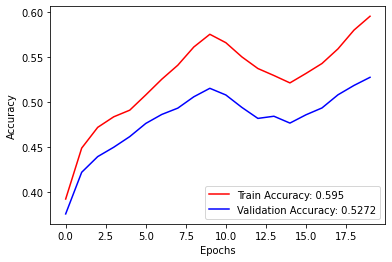

In [70]:
plot_training_validation(training_accuracy, validation_accuracy, plot_accuracy=True)

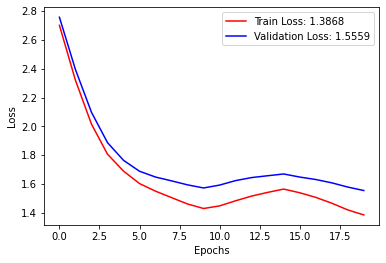

In [71]:
plot_training_validation(training_loss, validation_loss, plot_accuracy=False)

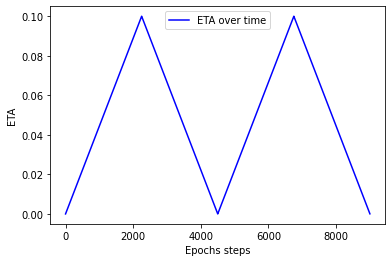

In [72]:
plt.plot(eta_evolution, color='blue', label='ETA over time')
plt.legend()
plt.xlabel("Epochs steps")
plt.ylabel('ETA')
plt.savefig('CLR_ETA.png')
plt.show()

## 9-layer network

In [78]:
layer_sizes = [training_x_norm.shape[0],50,30,20,20,10,10,10,10,10]
W, b, gamma, beta = init_params(layer_sizes, He=True, BN=False)

In [79]:
n_batch = 100
n_s = int(5*45000/n_batch)
n_epochs = 20
eta_min = 1e-5
eta_max = 1e-1
lambda_val = 0.005
(   W, 
    b, 
    gamma, 
    beta, 
    training_accuracy,
    training_loss, 
    validation_accuracy, 
    validation_loss, 
    eta_evolution, 
    average_mean, 
    average_var) = gradient_descent(training_x_norm,
                                        training_encoded, 
                                        training_y,
                                        validation_x_norm,
                                        validation_encoded,
                                        validation_y,
                                        n_batch=n_batch,
                                        eta=1e-5,
                                        n_epochs=n_epochs,
                                        W=W,
                                        b=b,
                                        gamma=gamma,
                                        beta=beta,
                                        lambda_val=lambda_val,
                                        alpha=None,
                                        eta_min=1e-5,
                                        eta_max=1e-1,
                                        n_s=n_s,
                                        use_CLR=True,
                                        BN=False
                                        )

100%|██████████| 20/20 [04:31<00:00, 13.59s/it]


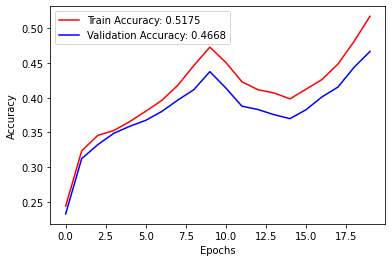

In [80]:
plot_training_validation(training_accuracy, validation_accuracy, plot_accuracy=True)

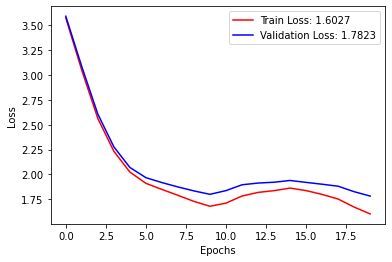

In [81]:
plot_training_validation(training_loss, validation_loss, plot_accuracy=False)

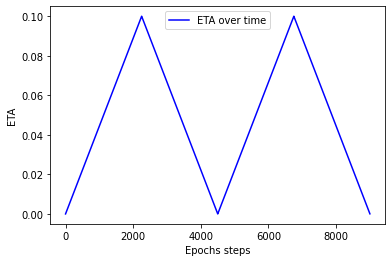

In [82]:
plt.plot(eta_evolution, color='blue', label='ETA over time')
plt.legend()
plt.xlabel("Epochs steps")
plt.ylabel('ETA')
plt.savefig('CLR_ETA.png')
plt.show()

# Batch normalization

## 3-layer network

In [73]:
layer_sizes = [training_x_norm.shape[0],50,50,10]
W, b, gamma, beta = init_params(layer_sizes, He=True, BN=True)

In [74]:
n_batch = 100
n_s = int(5*45000/n_batch)
n_epochs = 20
eta_min = 1e-5
eta_max = 1e-1
lambda_val = 0.005
(   W, 
    b, 
    gamma, 
    beta, 
    training_accuracy,
    training_loss, 
    validation_accuracy, 
    validation_loss, 
    eta_evolution, 
    average_mean, 
    average_var) = gradient_descent(training_x_norm,
                                        training_encoded, 
                                        training_y,
                                        validation_x_norm,
                                        validation_encoded,
                                        validation_y,
                                        n_batch=n_batch,
                                        eta=1e-5,
                                        n_epochs=n_epochs,
                                        W=W,
                                        b=b,
                                        gamma=gamma,
                                        beta=beta,
                                        lambda_val=lambda_val,
                                        alpha=.9,
                                        eta_min=1e-5,
                                        eta_max=1e-1,
                                        n_s=n_s,
                                        use_CLR=True,
                                        BN=True
                                        )

100%|██████████| 20/20 [04:33<00:00, 13.66s/it]


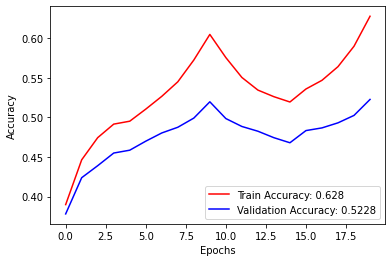

In [75]:
plot_training_validation(training_accuracy, validation_accuracy, plot_accuracy=True)

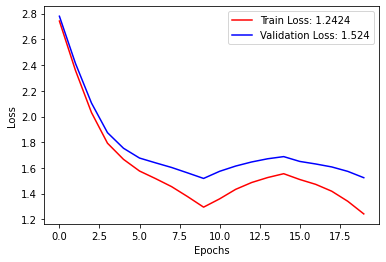

In [76]:
plot_training_validation(training_loss, validation_loss, plot_accuracy=False)

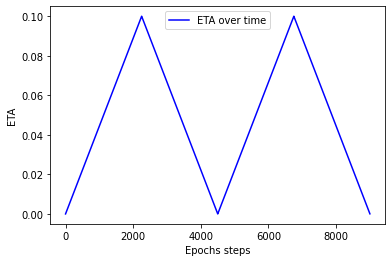

In [77]:
plt.plot(eta_evolution, color='blue', label='ETA over time')
plt.legend()
plt.xlabel("Epochs steps")
plt.ylabel('ETA')
plt.savefig('CLR_ETA.png')
plt.show()

## 9-layer network

In [83]:
layer_sizes = [training_x_norm.shape[0],50,30,20,20,10,10,10,10,10]
W, b, gamma, beta = init_params(layer_sizes, He=True, BN=True)

In [84]:
n_batch = 100
n_s = int(5*45000/n_batch)
n_epochs = 20
eta_min = 1e-5
eta_max = 1e-1
lambda_val = 0.005
(   W, 
    b, 
    gamma, 
    beta, 
    training_accuracy,
    training_loss, 
    validation_accuracy, 
    validation_loss, 
    eta_evolution, 
    average_mean, 
    average_var) = gradient_descent(training_x_norm,
                                        training_encoded, 
                                        training_y,
                                        validation_x_norm,
                                        validation_encoded,
                                        validation_y,
                                        n_batch=n_batch,
                                        eta=1e-5,
                                        n_epochs=n_epochs,
                                        W=W,
                                        b=b,
                                        gamma=gamma,
                                        beta=beta,
                                        lambda_val=lambda_val,
                                        alpha=.9,
                                        eta_min=1e-5,
                                        eta_max=1e-1,
                                        n_s=n_s,
                                        use_CLR=True,
                                        BN=True
                                        )

100%|██████████| 20/20 [05:10<00:00, 15.52s/it]


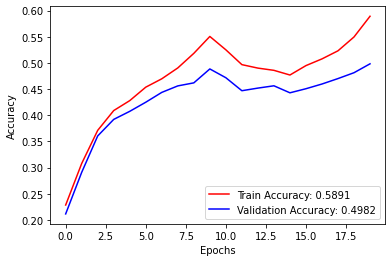

In [85]:
plot_training_validation(training_accuracy, validation_accuracy, plot_accuracy=True)

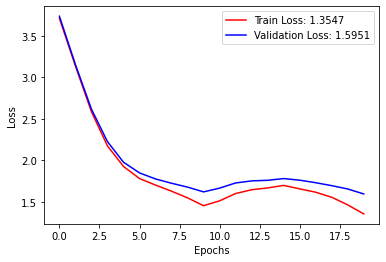

In [86]:
plot_training_validation(training_loss, validation_loss, plot_accuracy=False)


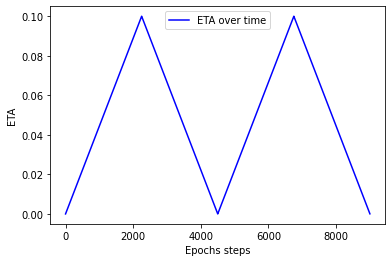

In [87]:
plt.plot(eta_evolution, color='blue', label='ETA over time')
plt.legend()
plt.xlabel("Epochs steps")
plt.ylabel('ETA')
plt.savefig('CLR_ETA.png')
plt.show()

# Lambda search

In [90]:
layer_sizes = [training_x_norm.shape[0],50,50,10]
W, b, gamma, beta = init_params(layer_sizes, He=True, BN=True)

In [93]:
l_min = -5
l_max = -1
l = l_min + (l_max-l_min)*np.random.rand(10)
list_of_lambdas = 10**l
n_batch = 100
n_s = int(5*45000/n_batch)
n_epochs = 20
eta_min = 1e-5
eta_max = 1e-1
lambda_val = 0.005
accuracies = pd.DataFrame({'Lambda':[], 'Accuracy':[]})
for lambda_val in list_of_lambdas:
    (_, 
    _, 
    _, 
    _, 
    training_accuracy,
    training_loss, 
    validation_accuracy, 
    validation_loss, 
    eta_evolution, 
    average_mean, 
    average_var) = gradient_descent(training_x_norm,
                                    training_encoded, 
                                    training_y,
                                    validation_x_norm,
                                    validation_encoded,
                                    validation_y,
                                    n_batch=n_batch,
                                    eta=1e-5,
                                    n_epochs=n_epochs,
                                    W=W,
                                    b=b,
                                    gamma=gamma,
                                    beta=beta,
                                    lambda_val=lambda_val,
                                    alpha=.9,
                                    eta_min=1e-5,
                                    eta_max=1e-1,
                                    n_s=n_s,
                                    use_CLR=True,
                                    BN=True
                                    )
    accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)
    print(max(validation_accuracy))
    """plt.plot(eta_evolution, color='blue', label='ETA over time')
    plt.legend()
    plt.xlabel("Epochs steps")
    plt.ylabel('ETA')
    plt.savefig('CLR_ETA.png')
    plt.show()"""

accuracies.sort_values(['Accuracy'], inplace=True)
print(accuracies)

100%|██████████| 20/20 [03:49<00:00, 11.47s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\4217629839.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.5022


100%|██████████| 20/20 [03:46<00:00, 11.33s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\4217629839.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.5056


100%|██████████| 20/20 [03:44<00:00, 11.23s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\4217629839.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.5034


100%|██████████| 20/20 [03:45<00:00, 11.26s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\4217629839.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.511


100%|██████████| 20/20 [03:50<00:00, 11.55s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\4217629839.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.496


100%|██████████| 20/20 [03:46<00:00, 11.31s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\4217629839.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.498


100%|██████████| 20/20 [03:44<00:00, 11.21s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\4217629839.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.518


100%|██████████| 20/20 [03:43<00:00, 11.17s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\4217629839.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.4996


100%|██████████| 20/20 [03:44<00:00, 11.24s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\4217629839.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.5252


100%|██████████| 20/20 [03:45<00:00, 11.25s/it]

0.5194
     Lambda  Accuracy
4  0.000013    0.4960
5  0.000118    0.4980
7  0.000032    0.4996
0  0.000047    0.5022
2  0.000395    0.5034
1  0.049369    0.5056
3  0.001223    0.5110
6  0.020373    0.5180
9  0.003140    0.5194
8  0.004764    0.5252



C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\4217629839.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


In [94]:
list_of_lambdas = [0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006]
n_batch = 100
n_s = int(5*45000/n_batch)
n_epochs = 20
eta_min = 1e-5
eta_max = 1e-1
lambda_val = 0.005
accuracies = pd.DataFrame({'Lambda':[], 'Accuracy':[]})
for lambda_val in list_of_lambdas:
    (_, 
    _, 
    _, 
    _, 
    training_accuracy,
    training_loss, 
    validation_accuracy, 
    validation_loss, 
    eta_evolution, 
    average_mean, 
    average_var) = gradient_descent(training_x_norm,
                                    training_encoded, 
                                    training_y,
                                    validation_x_norm,
                                    validation_encoded,
                                    validation_y,
                                    n_batch=n_batch,
                                    eta=1e-5,
                                    n_epochs=n_epochs,
                                    W=W,
                                    b=b,
                                    gamma=gamma,
                                    beta=beta,
                                    lambda_val=lambda_val,
                                    alpha=.9,
                                    eta_min=1e-5,
                                    eta_max=1e-1,
                                    n_s=n_s,
                                    use_CLR=True,
                                    BN=True
                                    )
    accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)
    print(max(validation_accuracy))
    """plt.plot(eta_evolution, color='blue', label='ETA over time')
    plt.legend()
    plt.xlabel("Epochs steps")
    plt.ylabel('ETA')
    plt.savefig('CLR_ETA.png')
    plt.show()"""

accuracies.sort_values(['Accuracy'], inplace=True)
print(accuracies)

100%|██████████| 20/20 [03:52<00:00, 11.63s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\1139389632.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.5202


100%|██████████| 20/20 [03:46<00:00, 11.30s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\1139389632.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.523


100%|██████████| 20/20 [03:46<00:00, 11.31s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\1139389632.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.5184


100%|██████████| 20/20 [03:46<00:00, 11.33s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\1139389632.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.5178


100%|██████████| 20/20 [03:42<00:00, 11.13s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\1139389632.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.5188


100%|██████████| 20/20 [03:43<00:00, 11.17s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\1139389632.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.5272


100%|██████████| 20/20 [03:43<00:00, 11.20s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\1139389632.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.5314


100%|██████████| 20/20 [03:43<00:00, 11.17s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\1139389632.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.5264


100%|██████████| 20/20 [03:42<00:00, 11.12s/it]
C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\1139389632.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


0.5306


100%|██████████| 20/20 [03:41<00:00, 11.08s/it]

0.5262
   Lambda  Accuracy
3  0.0030    0.5178
2  0.0025    0.5184
4  0.0035    0.5188
0  0.0015    0.5202
1  0.0020    0.5230
9  0.0060    0.5262
7  0.0050    0.5264
5  0.0040    0.5272
8  0.0055    0.5306
6  0.0045    0.5314



C:\Users\isakg\AppData\Local\Temp\ipykernel_2532\1139389632.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracies = accuracies.append({'Lambda': lambda_val, 'Accuracy':max(validation_accuracy)}, ignore_index=True)


In [95]:
layer_sizes = [training_x_norm.shape[0],50,50,10]
W, b, gamma, beta = init_params(layer_sizes, He=True, BN=True)

In [96]:
n_batch = 100
n_s = int(5*45000/n_batch)
n_epochs = 20
eta_min = 1e-5
eta_max = 1e-1
lambda_val = 0.0045
(   W, 
    b, 
    gamma, 
    beta, 
    training_accuracy,
    training_loss, 
    validation_accuracy, 
    validation_loss, 
    eta_evolution, 
    average_mean, 
    average_var) = gradient_descent(training_x_norm,
                                        training_encoded, 
                                        training_y,
                                        validation_x_norm,
                                        validation_encoded,
                                        validation_y,
                                        n_batch=n_batch,
                                        eta=1e-5,
                                        n_epochs=n_epochs,
                                        W=W,
                                        b=b,
                                        gamma=gamma,
                                        beta=beta,
                                        lambda_val=lambda_val,
                                        alpha=.9,
                                        eta_min=1e-5,
                                        eta_max=1e-1,
                                        n_s=n_s,
                                        use_CLR=True,
                                        BN=True
                                        )

100%|██████████| 20/20 [03:59<00:00, 11.99s/it]


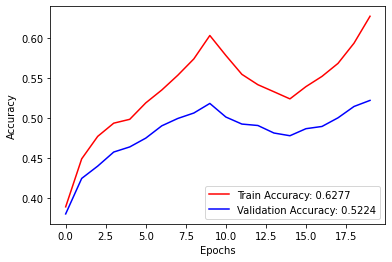

In [97]:
plot_training_validation(training_accuracy, validation_accuracy, plot_accuracy=True)


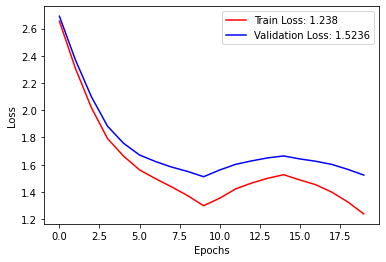

In [98]:
plot_training_validation(training_loss, validation_loss, plot_accuracy=False)

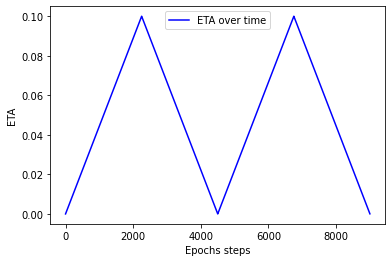

In [99]:
plt.plot(eta_evolution, color='blue', label='ETA over time')
plt.legend()
plt.xlabel("Epochs steps")
plt.ylabel('ETA')
plt.savefig('CLR_ETA.png')
plt.show()

# Sensitivity to initialisation

## 1e-1

In [140]:
n_batch = 100
n_s = int(2*45000/n_batch)
n_epochs = 20
eta_min = 1e-5
eta_max = 1e-1
lambda_val = 0.0045
W, b, gamma, beta = init_params(layer_sizes, mean=0.0, std_dev=1e-1, He=False, BN=True)
(   _, 
    _, 
    _, 
    _, 
    training_accuracy2,
    training_loss2, 
    validation_accuracy2, 
    validation_loss2, 
    eta_evolution, 
    average_mean, 
    average_var) = gradient_descent(training_x_norm,
                                        training_encoded, 
                                        training_y,
                                        validation_x_norm,
                                        validation_encoded,
                                        validation_y,
                                        n_batch=n_batch,
                                        eta=1e-5,
                                        n_epochs=n_epochs,
                                        W=W,
                                        b=b,
                                        gamma=gamma,
                                        beta=beta,
                                        lambda_val=lambda_val,
                                        alpha=.9,
                                        eta_min=1e-5,
                                        eta_max=1e-1,
                                        n_s=n_s,
                                        use_CLR=True,
                                        BN=True
                                        )
W, b, gamma, beta = init_params(layer_sizes, mean=0.0, std_dev=1e-1, He=False, BN=False)
(   _, 
    _, 
    _, 
    _, 
    training_accuracy1,
    training_loss1, 
    validation_accuracy1, 
    validation_loss1, 
    eta_evolution, 
    average_mean, 
    average_var) = gradient_descent(training_x_norm,
                                        training_encoded, 
                                        training_y,
                                        validation_x_norm,
                                        validation_encoded,
                                        validation_y,
                                        n_batch=n_batch,
                                        eta=1e-5,
                                        n_epochs=n_epochs,
                                        W=W,
                                        b=b,
                                        gamma=gamma,
                                        beta=beta,
                                        lambda_val=lambda_val,
                                        alpha=.9,
                                        eta_min=1e-5,
                                        eta_max=1e-1,
                                        n_s=n_s,
                                        use_CLR=True,
                                        BN=False
                                        )

100%|██████████| 20/20 [05:00<00:00, 15.00s/it]


## 1e-3

In [145]:
n_batch = 100
n_s = int(2*45000/n_batch)
n_epochs = 20
eta_min = 1e-5
eta_max = 1e-1
lambda_val = 0.0045
W, b, gamma, beta = init_params(layer_sizes, mean=0.0, std_dev=1e-3, He=False, BN=False)
(   _, 
    _, 
    _, 
    _, 
    training_accuracy3,
    training_loss3, 
    validation_accuracy3, 
    validation_loss3, 
    eta_evolution, 
    average_mean, 
    average_var) = gradient_descent(training_x_norm,
                                        training_encoded, 
                                        training_y,
                                        validation_x_norm,
                                        validation_encoded,
                                        validation_y,
                                        n_batch=n_batch,
                                        eta=1e-5,
                                        n_epochs=n_epochs,
                                        W=W,
                                        b=b,
                                        gamma=gamma,
                                        beta=beta,
                                        lambda_val=lambda_val,
                                        alpha=.9,
                                        eta_min=1e-5,
                                        eta_max=1e-1,
                                        n_s=n_s,
                                        use_CLR=True,
                                        BN=False
                                        )
W, b, gamma, beta = init_params(layer_sizes, mean=0.0, std_dev=1e-3, He=False, BN=True)
(   _, 
    _, 
    _, 
    _, 
    training_accuracy4,
    training_loss4, 
    validation_accuracy4, 
    validation_loss4, 
    eta_evolution, 
    average_mean, 
    average_var) = gradient_descent(training_x_norm,
                                        training_encoded, 
                                        training_y,
                                        validation_x_norm,
                                        validation_encoded,
                                        validation_y,
                                        n_batch=n_batch,
                                        eta=1e-5,
                                        n_epochs=n_epochs,
                                        W=W,
                                        b=b,
                                        gamma=gamma,
                                        beta=beta,
                                        lambda_val=lambda_val,
                                        alpha=.9,
                                        eta_min=1e-5,
                                        eta_max=1e-1,
                                        n_s=n_s,
                                        use_CLR=True,
                                        BN=True
                                        )

100%|██████████| 20/20 [05:39<00:00, 16.99s/it]


## 1e-4

In [151]:
n_batch = 100
n_s = int(2*45000/n_batch)
n_epochs = 20
eta_min = 1e-5
eta_max = 1e-1
lambda_val = 0.0045
W, b, gamma, beta = init_params(layer_sizes, mean=0.0, std_dev=1e-4, He=False, BN=False)
(   _, 
    _, 
    _, 
    _, 
    training_accuracy5,
    training_loss5, 
    validation_accuracy5, 
    validation_loss5, 
    eta_evolution, 
    average_mean, 
    average_var) = gradient_descent(training_x_norm,
                                        training_encoded, 
                                        training_y,
                                        validation_x_norm,
                                        validation_encoded,
                                        validation_y,
                                        n_batch=n_batch,
                                        eta=1e-5,
                                        n_epochs=n_epochs,
                                        W=W,
                                        b=b,
                                        gamma=gamma,
                                        beta=beta,
                                        lambda_val=lambda_val,
                                        alpha=.9,
                                        eta_min=1e-5,
                                        eta_max=1e-1,
                                        n_s=n_s,
                                        use_CLR=True,
                                        BN=False
                                        )
W, b, gamma, beta = init_params(layer_sizes, mean=0.0, std_dev=1e-4, He=False, BN=True)
(   _, 
    _, 
    _, 
    _, 
    training_accuracy6,
    training_loss6, 
    validation_accuracy6, 
    validation_loss6, 
    eta_evolution, 
    average_mean, 
    average_var) = gradient_descent(training_x_norm,
                                        training_encoded, 
                                        training_y,
                                        validation_x_norm,
                                        validation_encoded,
                                        validation_y,
                                        n_batch=n_batch,
                                        eta=1e-5,
                                        n_epochs=n_epochs,
                                        W=W,
                                        b=b,
                                        gamma=gamma,
                                        beta=beta,
                                        lambda_val=lambda_val,
                                        alpha=.9,
                                        eta_min=1e-5,
                                        eta_max=1e-1,
                                        n_s=n_s,
                                        use_CLR=True,
                                        BN=True
                                        )

100%|██████████| 20/20 [03:44<00:00, 11.22s/it]


In [155]:
print('Loss without batch normalisation and sigma = {}: {}'.format(str(1e-1),str(round(validation_loss2[-1],4))))
print('Loss with batch normalisation and sigma = {}: {}'.format(str(1e-1),str(round(validation_loss1[-1],4))))

print('Loss without batch normalisation and sigma = {}: {}'.format(str(1e-3),str(round(validation_loss3[-1],4))))
print('Loss with batch normalisation and sigma = {}: {}'.format(str(1e-3),str(round(validation_loss4[-1],4))))

print('Loss without batch normalisation and sigma = {}: {}'.format(str(1e-4),str(round(validation_loss5[-1],4))))
print('Loss with batch normalisation and sigma = {}: {}'.format(str(1e-4),str(round(validation_loss6[-1],4))))

Loss without batch normalisation and sigma = 0.1: 1.5216
Loss with batch normalisation and sigma = 0.1: 1.5543
Loss without batch normalisation and sigma = 0.001: 2.1213
Loss with batch normalisation and sigma = 0.001: 1.5411
Loss without batch normalisation and sigma = 0.0001: 2.3028
Loss with batch normalisation and sigma = 0.0001: 1.5367
